In [0]:
!git clone -b dev https://github.com/nyikovicsmate/thesis

Cloning into 'thesis'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 1685 (delta 157), reused 206 (delta 112), pack-reused 1419
Receiving objects: 100% (1685/1685), 199.11 MiB | 29.75 MiB/s, done.
Resolving deltas: 100% (646/646), done.


In [0]:
%cd thesis

/content/thesis


In [0]:
!pip3 install -q gdown
# bsd500_gray.zip
!gdown https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
!unzip -q bsd500_gray.zip
# # bsd500_color.zip
!gdown https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
!unzip -q bsd500_color.zip
# # set14_color.zip
!gdown https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
!unzip -q set14_color.zip

Downloading...
From: https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
To: /content/thesis/bsd500_gray.zip
11.3MB [00:00, 99.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
To: /content/thesis/bsd500_color.zip
29.4MB [00:00, 93.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
To: /content/thesis/set14_color.zip
100% 831k/831k [00:00<00:00, 54.9MB/s]


In [0]:
%tensorflow_version 2.x
from src.callbacks import *
from src.dataset import *
import numpy as np
import tensorflow as tf

from src.networks.adversarial.pre_upsampling_network import AdversarialPreUpsamplingNetwork

In [0]:
seed = 1111

normalize = lambda x: np.asarray(x / 255.0, dtype=np.float32)
downsample = lambda x: np.array([cv2.resize(x_i, (x.shape[2]//2, x.shape[1]//2), interpolation=cv2.INTER_CUBIC) for x_i in x])

ds = HDFDataset("bsd500_70_70_color.h5").shuffle(seed).transform()
ds_g_hr = ds.batch(20).map(normalize)
ds_g_lr = ds.batch(20).map(downsample).map(normalize)
ds_d_hr = ds.batch(20).map(normalize)
ds_d_lr = ds.batch(20).map(downsample).map(normalize)

# cb_g = [TrainingCheckpointCallback(appendix="_ad_pre", save_freq=10),
#        ExponentialDecayCallback(learning_rate, epochs, decay_rate=0.9)]
# cb_d = [TrainingCheckpointCallback(appendix="_ad_pre", save_freq=10),
#        ExponentialDecayCallback(learning_rate, epochs, decay_rate=0.9)]

In [0]:
network = AdversarialPreUpsamplingNetwork((None, None, 3))
network.train(ds_g_lr, ds_g_hr,
              ds_d_lr, ds_d_hr,
              generator_epochs=1800,
              discriminator_epochs=1200,
              alternating_ratio=20,
              generator_lr=1e-8,
              discriminator_lr=1e-8,
              generator_callbacks=[],
              discriminator_callbacks=[])

[2020-05-21 05:06:21,320] INFO load_state(): Loaded state with: 
Train time: 01h:29m:49s
Epochs:     4940
Loss:       16146.0498
[2020-05-21 05:06:21,361] INFO load_state(): Loaded state with: 
Train time: 00h:03m:53s
Epochs:     148
Loss:       0.4277
[2020-05-21 05:06:21,363] INFO train(): Training discriminator network.
[2020-05-21 05:06:31,642] INFO _train(): Epoch: 0 train_loss: 1.66
[2020-05-21 05:06:33,960] INFO _train(): Epoch: 1 train_loss: 4.16
[2020-05-21 05:06:36,289] INFO _train(): Epoch: 2 train_loss: 1.91
[2020-05-21 05:06:38,634] INFO _train(): Epoch: 3 train_loss: 1.59
[2020-05-21 05:06:40,956] INFO _train(): Epoch: 4 train_loss: 3.98
[2020-05-21 05:06:43,262] INFO _train(): Epoch: 5 train_loss: 4.66
[2020-05-21 05:06:45,585] INFO _train(): Epoch: 6 train_loss: 3.85
[2020-05-21 05:06:47,901] INFO _train(): Epoch: 7 train_loss: 2.07
[2020-05-21 05:06:50,201] INFO _train(): Epoch: 8 train_loss: 3.15
[2020-05-21 05:06:52,522] INFO _train(): Epoch: 9 train_loss: 3.05
[2020

[2020-05-21 07:03:24,491] INFO _parse_predict_optionals(): Predicting using the default upsampling factor of 2.
[2020-05-21 07:03:24,663] INFO _predict(): Predicted images with shape: (14, 70, 70, 3)
   HR   ALIASED   NETWORK   


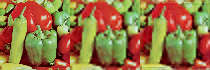

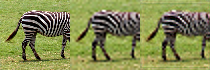

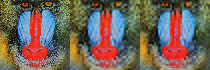

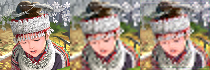

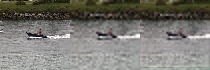

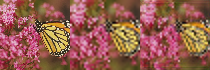

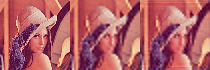

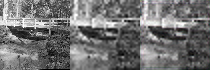

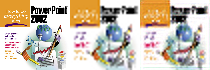

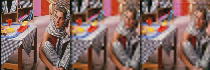

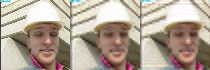

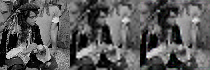

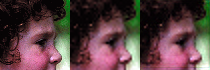

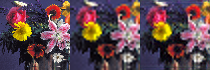

SSIM
max: [10] 0.85    min: [1] 0.59    avg: 0.69
TOTAL_VARIATION
max: [3] 1984.49    min: [12] 842.36    avg: 1520.80
PSNR
max: [12] 27.19    min: [8] 15.81    avg: 20.55
MEAN_SQUARED_ERROR
max: [8] 128.49    min: [12] 9.37    avg: 51.72
MEAN_ABSOLUTE_ERROR
max: [8] 482.68    min: [12] 148.09    avg: 329.64


In [0]:
from google.colab.patches import cv2_imshow

ds_ev_lr = DirectoryDataset("set14_70_70_color").map(downsample).map(normalize)
ds_ev_hr = DirectoryDataset("set14_70_70_color").map(normalize)

network.save_state(generator_appendix="_ad_pre", discriminator_appendix="_ad_pre")
# load best network state
network.load_state(generator_appendix="_ad_pre", discriminator_appendix="_ad_pre")

with ds_ev_lr as x, ds_ev_hr as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

In [0]:
%cd checkpoints/
!zip -r preupsamplingnetwork_adversarial.zip ./discriminatornetwork_ad_pre ./preupsamplingnetwork_ad_pre
%cd ..

/content/thesis/checkpoints
  adding: discriminatornetwork_ad_pre/ (stored 0%)
  adding: discriminatornetwork_ad_pre/weights.data-00001-of-00002 (deflated 8%)
  adding: discriminatornetwork_ad_pre/weights.index (deflated 67%)
  adding: discriminatornetwork_ad_pre/checkpoint (deflated 37%)
  adding: discriminatornetwork_ad_pre/weights.data-00000-of-00002 (deflated 79%)
  adding: discriminatornetwork_ad_pre/state.dat (deflated 15%)
  adding: preupsamplingnetwork_ad_pre/ (stored 0%)
  adding: preupsamplingnetwork_ad_pre/weights.data-00001-of-00002 (deflated 7%)
  adding: preupsamplingnetwork_ad_pre/weights.index (deflated 54%)
  adding: preupsamplingnetwork_ad_pre/checkpoint (deflated 37%)
  adding: preupsamplingnetwork_ad_pre/weights.data-00000-of-00002 (deflated 70%)
  adding: preupsamplingnetwork_ad_pre/state.dat (deflated 14%)
/content/thesis


In [0]:
from google.colab.files import download

download("./checkpoints/preupsamplingnetwork_adversarial.zip")